<a href="https://colab.research.google.com/github/isan23/Week-3/blob/main/Week3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# === Setup ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# === Load CSV (your uploaded file) ===
# If your file name is different, update the path below:
df = pd.read_csv('/content/titanic.csv')  # <- change path if needed

print("Shape:", df.shape)
df.head(10)


Shape: (891, 8)


/tmp/ipython-input-1407279138.py:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


,PassengerId,Pclass,Name,Sex,Age,Ticket,Fare,Survived
0,1,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,1
2,3,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.9250,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,113803,53.1000,1
4,5,3,"Allen, Mr. William Henry",male,35.0,373450,8.0500,0
5,6,3,"Moran, Mr. James",male,NaN,330877,8.4583,0
6,7,1,"McCarthy, Mr. Timothy J",male,54.0,17463,51.8625,0
7,8,3,"Palsson, Master. Gosta Leonard",male,2.0,349909,21.0750,0
8,9,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,347742,11.1333,1
9,10,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,237736,30.0708,1


In [ ]:
# Try to match common Titanic column names regardless of case
lower = {c.lower(): c for c in df.columns}
target_col = lower.get("survived", None)
if target_col is None:
    raise ValueError("Could not find a 'Survived' column in the file.")

# Typical features used for a simple baseline model
feature_candidates = ["pclass","sex","age","sibsp","parch","fare","embarked"]
features = [lower[c] for c in feature_candidates if c in lower]

X = df[features].copy()
y = df[target_col].copy()

# Drop rows where target is missing
mask = ~y.isna()
X, y = X.loc[mask], y.loc[mask]

print("Target distribution (0=died, 1=survived):")
print(y.value_counts(dropna=False))


Target distribution (0=died, 1=survived):
Survived
0    549
1    342
Name: count, dtype: int64


In [ ]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Columns by type
num_cols = [c for c in X.columns if X[c].dtype != "object"]
cat_cols = [c for c in X.columns if X[c].dtype == "object"]

# Transformers
from sklearn.pipeline import Pipeline

num_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

from sklearn.compose import ColumnTransformer
preprocess = ColumnTransformer(
    transformers=[
        ("num", num_tf, num_cols),
        ("cat", cat_tf, cat_cols)
    ]
)


=== Logistic Regression ===
Accuracy: 0.771
              precision    recall  f1-score   support

           0       0.83      0.80      0.81       137
           1       0.69      0.73      0.71        86

    accuracy                           0.77       223
   macro avg       0.76      0.76      0.76       223
weighted avg       0.77      0.77      0.77       223



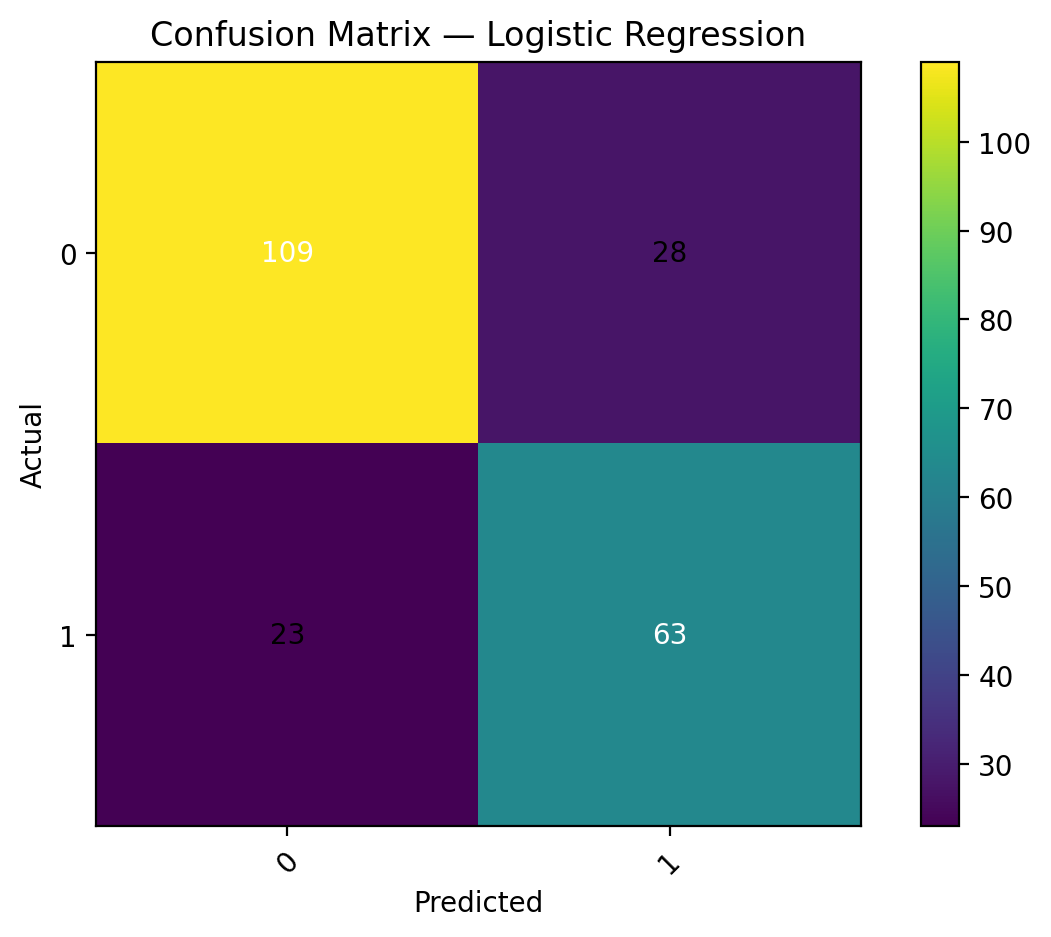

In [ ]:
# Build pipeline
logreg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=300, solver="liblinear"))
])

# Train & predict
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)

# Metrics
acc_lr = accuracy_score(y_test, y_pred_lr)
print("=== Logistic Regression ===")
print(f"Accuracy: {acc_lr:.3f}")
print(classification_report(y_test, y_pred_lr))

# Confusion matrix plot (matplotlib only; no custom colors)
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure()
plt.imshow(cm_lr, interpolation="nearest")
plt.title("Confusion Matrix — Logistic Regression")
plt.colorbar()
ticks = np.arange(len(sorted(y.unique())))
plt.xticks(ticks, sorted(y.unique()), rotation=45)
plt.yticks(ticks, sorted(y.unique()))
thresh = cm_lr.max()/2.0
for i in range(cm_lr.shape[0]):
    for j in range(cm_lr.shape[1]):
        plt.text(j, i, format(cm_lr[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm_lr[i, j] > thresh else "black")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()


=== KNN (k=5) ===
Accuracy: 0.803
              precision    recall  f1-score   support

           0       0.80      0.90      0.85       137
           1       0.80      0.65      0.72        86

    accuracy                           0.80       223
   macro avg       0.80      0.77      0.78       223
weighted avg       0.80      0.80      0.80       223



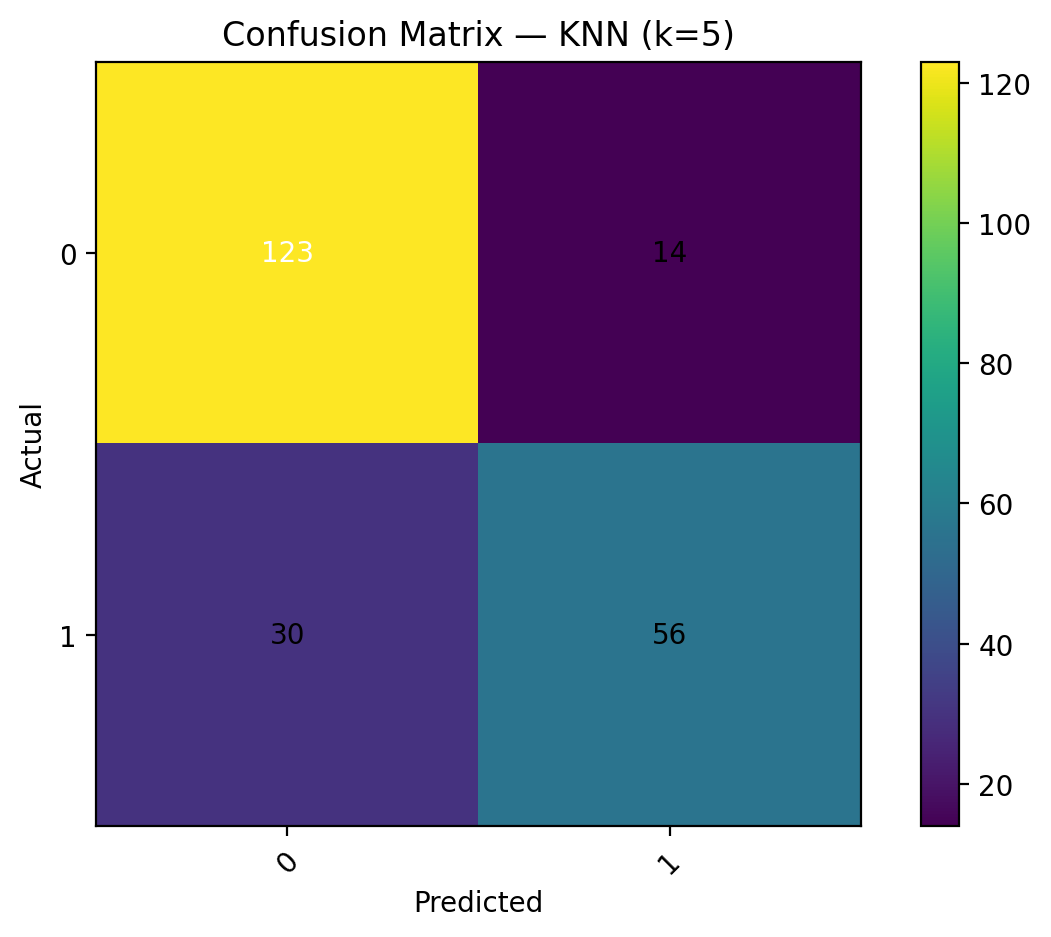

In [ ]:
knn = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", KNeighborsClassifier(n_neighbors=5))
])

knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

acc_knn = accuracy_score(y_test, y_pred_knn)
print("=== KNN (k=5) ===")
print(f"Accuracy: {acc_knn:.3f}")
print(classification_report(y_test, y_pred_knn))

cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure()
plt.imshow(cm_knn, interpolation="nearest")
plt.title("Confusion Matrix — KNN (k=5)")
plt.colorbar()
ticks = np.arange(len(sorted(y.unique())))
plt.xticks(ticks, sorted(y.unique()), rotation=45)
plt.yticks(ticks, sorted(y.unique()))
thresh = cm_knn.max()/2.0
for i in range(cm_knn.shape[0]):
    for j in range(cm_knn.shape[1]):
        plt.text(j, i, format(cm_knn[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm_knn[i, j] > thresh else "black")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()
